In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

dataset = pd.read_csv("../data/logfile-storage-v3.csv", delimiter=";")
dataset.head()

,datacenter_id,datacenter_name,datacenter_storage_energy,storage_id,system,storage_capacity,capacity_used,active_duration,idle_intervals,duration,total_energy_active,total_energy_idle,average_rotation_latency,average_seek_Time,max_internal_data_transfer_rate,is_active,idle_power,active_power,files,Unnamed: 19
0,3,datacenter,74620.259307,1,storage,900000.0,14848.0,75.045989,1.000011843801415:,316.533532,435.266735,3.000036,0.003,0.004,198.0,False,3.0,5.8,"55596,3072,15.527644938419229:2-878231,1024,5....",NaN
1,3,datacenter,74620.259307,2,storage,900000.0,25088.0,126.765213,1.0000001634360047:,316.533532,735.238233,3.000000,0.003,0.004,198.0,False,3.0,5.8,"1-612639,4096,20.692570051259533:304371,3584,1...",NaN
2,3,datacenter,74620.259307,3,storage,900000.0,24576.0,139.717016,1.000000197764156:,316.533532,810.358690,3.000001,0.003,0.004,198.0,False,3.0,5.8,"1-55872,3072,15.521324441002905:303623,3584,18...",NaN
3,3,datacenter,74620.259307,4,storage,900000.0,30720.0,168.149131,1.0000003700028652:,316.533532,975.264957,3.000001,0.003,0.004,198.0,False,3.0,5.8,"1-878237,1024,5.187122965529541:304462,3584,18...",NaN
4,3,datacenter,74620.259307,5,storage,900000.0,12800.0,64.705854,1.0000004590101392:,316.533532,375.293953,3.000001,0.003,0.004,198.0,False,3.0,5.8,"16601,512,2.596673335321235:285602,512,2.60125...",NaN


### Storage placement

#### Current data placement

In [2]:
labels = np.unique(dataset['datacenter_name'])
files_per_datacenter = np.array([])
files_per_host = np.array([])
for i in range(len(labels)):
    files_per_datacenter_per_host = np.array([])
    
    for index, sample in dataset[dataset['datacenter_name'] == labels[i]].iterrows():
        if pd.notna(sample['files']):
            files = len(sample['files'].split(":"))-1
            print(f"Disk ID '{sample['storage_id']}' at datacenter '{sample['datacenter_name']}' has {files} stored files.")
            files_per_host = np.append(files_per_host, files)
            files_per_datacenter_per_host = np.append(files_per_datacenter_per_host, files)
    files_per_datacenter = np.append(files_per_datacenter, sum(files_per_datacenter_per_host))

for i in range(len(labels)):
    print(f"{files_per_datacenter[i]} stored files at datacenter '{labels[i]}'.")
print(f"The cloud provider has {sum(files_per_datacenter)} stored files.")


Disk ID '1' at datacenter 'datacenter' has 9 stored files.
Disk ID '2' at datacenter 'datacenter' has 9 stored files.
Disk ID '3' at datacenter 'datacenter' has 9 stored files.
Disk ID '4' at datacenter 'datacenter' has 9 stored files.
Disk ID '5' at datacenter 'datacenter' has 9 stored files.
Disk ID '6' at datacenter 'datacenter' has 9 stored files.
Disk ID '7' at datacenter 'datacenter' has 9 stored files.
Disk ID '8' at datacenter 'datacenter' has 9 stored files.
Disk ID '9' at datacenter 'datacenter' has 9 stored files.
Disk ID '10' at datacenter 'datacenter' has 9 stored files.
Disk ID '11' at datacenter 'datacenter' has 9 stored files.
Disk ID '12' at datacenter 'datacenter' has 9 stored files.
Disk ID '13' at datacenter 'datacenter' has 8 stored files.
Disk ID '14' at datacenter 'datacenter' has 8 stored files.
Disk ID '15' at datacenter 'datacenter' has 8 stored files.
Disk ID '16' at datacenter 'datacenter' has 8 stored files.
Disk ID '17' at datacenter 'datacenter' has 8 sto

#### Capacity aware data placement 

In [3]:

disks = []
files = []
for i, sample in dataset.iterrows():
    disks.append({
        "id": i,
        "datacenter": sample['datacenter_name'],
        "storage_capacity": float(sample['storage_capacity']),
        "capacity_used": float(sample['capacity_used']),
        "active_power": float(sample['active_power']),
        "idle_power": float(sample['idle_power'])

    })
    if pd.notna(sample['files']):
        for j, file in enumerate(sample['files'].split(":")):
            file_data = file.split(",")
            if len(file_data) != 3:
                continue
            files.append({
                "id": j,
                "filename": file_data[0],
                "filesize": float(file_data[1]),
                "transaction_time": float(file_data[2])
            })

files_copy = files.copy()
new_storage_placement = []
removed_files_from_copy = 0

for index_disk, disk in enumerate(disks):
    used_storage = 0
    files_per_disk = []
    for file in files_copy:
        if file['filesize'] + used_storage <= disk['storage_capacity']:
            used_storage += file['filesize']
            files_per_disk.append(file)
    
    # Adding to new list of placement of data and removing from the copy 
    new_storage_placement.append(files_per_disk)
    for index, file in enumerate(files_per_disk):
        run = True
        index = 0
        while run:
            if file['id'] == files_copy[index]['id']:
                del files_copy[index]
                run = False
            index += 1


Disk ID '0' has 276 stored files with capacity (899584.0/900000.0) as supposed to (14848.0/900000.0),
consuming the 39999.487336103935 over the duration 9090.893463608514s,
where the disk was idle for 4545.605268866231 which could have saved 13636.815806598694 if powered off.

Disk ID '1' has 328 stored files with capacity (899584.0/900000.0) as supposed to (25088.0/900000.0),
consuming the 40000.37514365099 over the duration 9090.893463608514s,
where the disk was idle for 4545.288194742283 which could have saved 13635.864584226849 if powered off.

Disk ID '2' has 208 stored files with capacity (625152.0/900000.0) as supposed to (24576.0/900000.0),
consuming the 36117.232975284496 over the duration 9090.893463608514s,
where the disk was idle for 5932.124683444601 which could have saved 17796.374050333805 if powered off.

Disk ID '3' has 0 stored files with capacity (0/900000.0) as supposed to (30720.0/900000.0),
can be powered off consuming 0 Joules (J) over the duration 9090.893463608

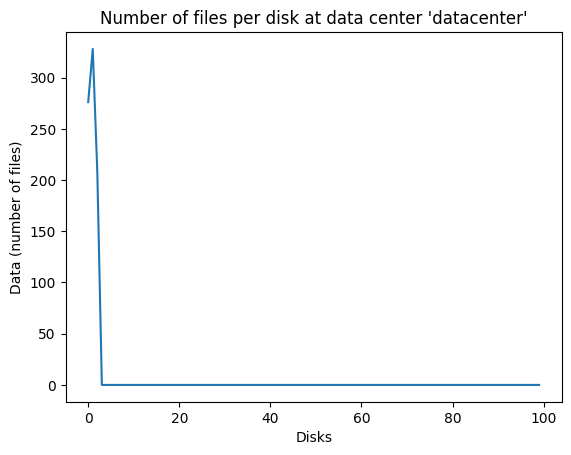

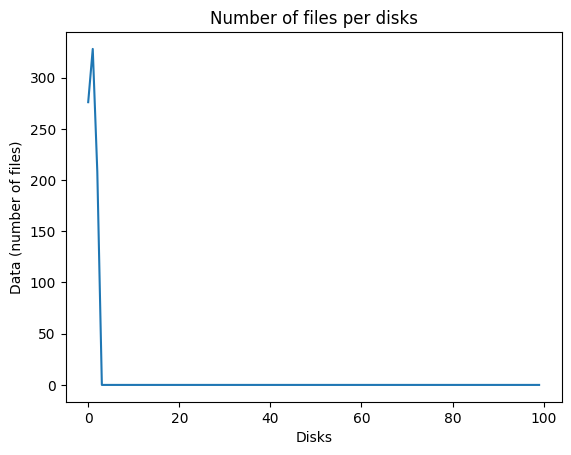

In [4]:
# Getting new duration
max_time = 0
for index_disk, disk in enumerate(new_storage_placement):
    transaction_time = 0
    for index_file, file in enumerate(disk):
        transaction_time += file['transaction_time']
    if transaction_time > max_time:
        max_time += transaction_time

# Calculating the capacity used per disk and power consumption.
new_data_placement_per_disk = np.array([])
new_data_placement_per_datacenter_per_disk = {}
for index_disk, disk in enumerate(new_storage_placement):
    transaction_time = 0
    capacity_used = 0
    files = len(disk)
    
    for index_file, file in enumerate(disk):
        capacity_used += file['filesize']
        transaction_time += file['transaction_time']
    
    
    new_data_placement_per_disk = np.append(new_data_placement_per_disk, files)
    if disks[index_disk]['datacenter'] not in new_data_placement_per_datacenter_per_disk.keys():
        # print(new_data_placement_per_datacenter_per_disk[hosts[index_host]['datacenter']])
        new_data_placement_per_datacenter_per_disk[disks[index_disk]['datacenter']] = np.array([])
    new_data_placement_per_datacenter_per_disk[disks[index_disk]['datacenter']] = np.append(new_data_placement_per_datacenter_per_disk[disks[index_disk]['datacenter']], files)
    
    
    if files != 0:
        print(f"Disk ID '{index_disk}' has {files} stored files with capacity ({capacity_used}/{disks[index_disk]['storage_capacity']}) as supposed to ({disks[index_disk]['capacity_used']}/{disks[index_disk]['storage_capacity']}),\nconsuming the {(disks[index_disk]['active_power']*transaction_time) + (disks[index_disk]['idle_power']*(max_time - transaction_time))} over the duration {max_time}s,\nwhere the disk was idle for {max_time - transaction_time} which could have saved {disks[index_disk]['idle_power']*(max_time - transaction_time)} if powered off.\n")
    else:
        print(f"Disk ID '{index_disk}' has {files} stored files with capacity ({capacity_used}/{disks[index_disk]['storage_capacity']}) as supposed to ({disks[index_disk]['capacity_used']}/{disks[index_disk]['storage_capacity']}),\ncan be powered off consuming 0 Joules (J) over the duration {max_time}s.\n")

for key in new_data_placement_per_datacenter_per_disk.keys():
    plt.plot(np.arange(len(new_data_placement_per_datacenter_per_disk[key])), new_data_placement_per_datacenter_per_disk[key], label="Files per host")
    plt.xlabel("Disks")
    plt.ylabel("Data (number of files)")
    plt.title(f"Number of files per disk at data center '{key}'")
    #plt.legend()
    plt.show()

plt.plot(np.arange(len(new_data_placement_per_disk)), new_data_placement_per_disk, label="Files per host")
plt.xlabel("Disks")
plt.ylabel("Data (number of files)")
plt.title("Number of files per disks")
#plt.legend()
plt.show()

#### Optimal capacity aware storage placement 